In [1]:
import gym
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
%matplotlib inline

# Pseudocode

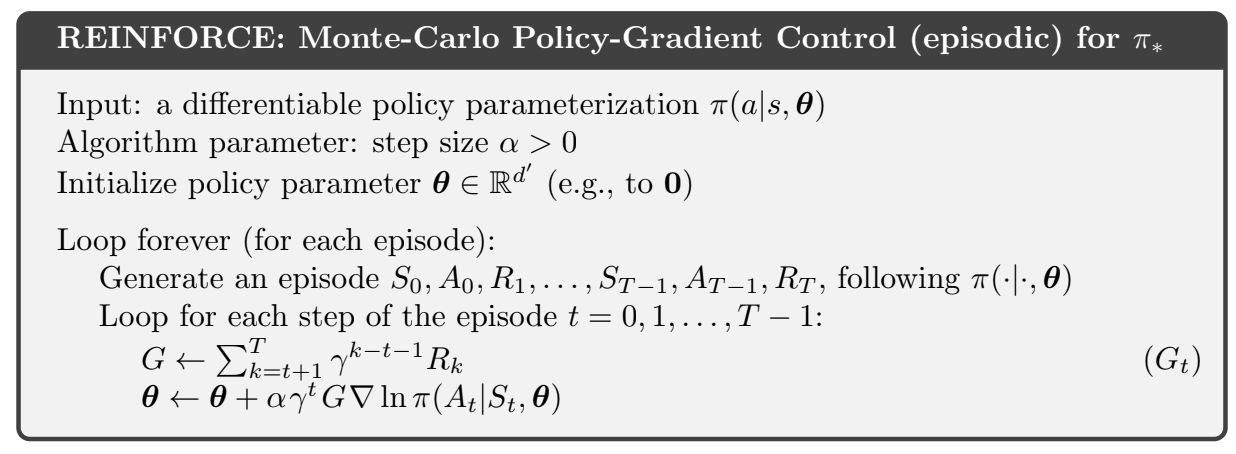

In [2]:
img = Image.open('pseudocode.png')
img

# Policy Gradient Neural Network

In [3]:
class PolicyGradientNetwork(models.Model):
    def __init__(self, input_sz, output_sz, hidden_sz):
        super(PolicyGradientNetwork, self).__init__()
        self.input_layer = layers.InputLayer(input_shape=(input_sz,))
        self.hidden_layer = [layers.Dense(i, activation='relu') for i in hidden_sz]
        self.output_layer = layers.Dense(output_sz, activation='softmax')
        

    def call(self, x):
        x = self.input_layer(x)
        for i in self.hidden_layer:
            x = i(x)
        return self.output_layer(x)
            

# Agent Class

In [101]:
class Agent():
    def __init__(self,
                state_sz=None,
                action_sz=None,
                hidden_sz=[256,256],
                lr=0.003,
                gamma=0.99):
        
        self.state_sz = state_sz
        self.action_sz = action_sz
        self.hidden_sz = hidden_sz
        self.gamma = gamma
        self.lr = lr
        self.state_sz = state_sz
        
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        
        self.policy_network = PolicyGradientNetwork(self.state_sz, self.action_sz, self.hidden_sz)
        self.optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        
        
    def get_action(self, state):
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        probs = tf.squeeze(self.policy_network.call(state)).numpy()
        action = np.random.choice(self.action_sz, p=probs)
        return action
        
    def store_transition(self, obs, action, reward):
        self.state_memory.append(obs)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        
    def learn(self):
        action = tf.convert_to_tensor(self.action_memory)
        reward = tf.convert_to_tensor(self.reward_memory)
        
        G = np.zeros_like(reward)
        
        for i in range(len(reward)):
            G_sum = 0
            discount = 1
            for j in range(i, len(reward)):
                G_sum += reward[j]*discount
                discount *= self.gamma
            G[i] = G_sum
        
        with tf.GradientTape() as tape:
            loss = 0
            for i, (g, state) in enumerate(zip(G, self.state_memory)):
                state = tf.convert_to_tensor(state, dtype=tf.float32)
                probs = tf.squeeze(self.policy_network.call(state)).numpy()
                log_prob = -np.log10(probs[action[i]])
                loss += g*tf.squeeze(log_prob)
        
        gradients = tape.gradient(loss, self.policy_network.trainable_variables) 
        self.optimizer.apply_gradients(zip(gradients, self.policy_network.trainable_variables))
        
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        

In [102]:
if __name__ == "__main__":
    
    env = gym.make('CartPole-v1')
    agent = Agent(env.observation_space.shape[0], env.action_space.n, [64,64,64])
    number_of_episodes = 100
    total_reward = np.zeros(number_of_episodes)
    
    for i in tqdm_notebook(range(number_of_episodes)):
        state = env.reset()
        state = np.reshape(state, [1,env.observation_space.shape[0]])
        
        while True:
            
            #env.render()
            
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1,env.observation_space.shape[0]])
            
            if done: 
                reward = -200
            else:
                reward = reward
                
            agent.store_transition(state, action, reward)
            state = next_state
            total_reward[i] += reward
            
            if done:
                #env.render()
                
                agent.learn()
                
                if i % 50 == 0:
                    
                    print(f'Episode: {i+1}')
                    print(f"Avg_Reward: {total_reward[:i+1].mean():.2f}")
                    print('='*18)
                
                break

plt.plot(total_reward)
plt.plot(talib.EMA(total_reward, timeperiod=50))
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Performance',fontsize=18)
plt.show()

env.close()          

<ipython-input-102-8b5070974a3a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(number_of_episodes)):


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: No gradients provided for any variable: ['dense_136/kernel:0', 'dense_136/bias:0', 'dense_137/kernel:0', 'dense_137/bias:0', 'dense_138/kernel:0', 'dense_138/bias:0', 'dense_139/kernel:0', 'dense_139/bias:0'].

In [80]:
state = env.reset()
state = np.reshape(state, [1,env.observation_space.shape[0]])
state = tf.convert_to_tensor(state, dtype=tf.float32)
state

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03713666, -0.00553194,  0.03243752,  0.04302472]],
      dtype=float32)>

In [82]:
agent.policy_network(state)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5012473, 0.4987527]], dtype=float32)>